# 2. Exploratory Data Analysis

In [1]:
# Import Dependencies
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import string
import re

plt.style.use('ggplot')

import nltk
nltk.download('punkt')                          # Download the necessary nltk data for word_tokenize
nltk.download('averaged_perceptron_tagger')     # Download the data for pos_tag
nltk.download('tagsets')                        # Download the data for pos_tag
nltk.download('wordnet')                        # Download the data for wordnet_pos
nltk.download('omw-1.4')                        # Download the data for wordnet_pos
nltk.download('maxent_ne_chunker')              # Download the data for ne_chunk
nltk.download('words')                          # Download the data for ne_chunk

import inflect
import contractions
import itertools
import collections
from collections import Counter
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords, wordnet
from nltk.stem import WordNetLemmatizer
from textblob import TextBlob
from wordcloud import WordCloud
from nltk.collocations import BigramAssocMeasures, BigramCollocationFinder
from nltk.collocations import TrigramAssocMeasures, TrigramCollocationFinder
from sklearn.preprocessing import LabelEncoder

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\debby\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\debby\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package tagsets to
[nltk_data]     C:\Users\debby\AppData\Roaming\nltk_data...
[nltk_data]   Package tagsets is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\debby\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\debby\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
[nltk_data] Downloading package maxent_ne_chunker to
[nltk_data]     C:\Users\debby\AppData\Roaming\nltk_data...
[nltk_data]   Package maxent_ne_chunker is already up-

In [2]:
# Read in data
df = pd.read_csv('reviews.csv')    
df = df.drop(df.columns[0], axis = 1)
df.head(1)

,Date,Place,Title,Rating,Content
0,1 August 2023,United Kingdom,Second time buying these headphones as overall...,4,I lost my first pair so I replaced them with t...


In [3]:
# df.info()

Let’s examine if we have any *missing values*:

In [4]:
for col in df.columns:
    print(col, df[col].isnull().sum())

Date 0
Place 0
Title 0
Rating 0
Content 0


Once evaluated that there are no missing values in each column, let's create a new DataFrame **rws** containing only the columns *'Title'*, *'Content'*, and *'Rating'* from the original *'df'*:

In [5]:
# Reviews DataFrame
rws = df.loc[:, ['Title', 'Content', 'Rating']]
rws.head(1)

,Title,Content,Rating
0,Second time buying these headphones as overall...,I lost my first pair so I replaced them with t...,4


The following function creates a new column named **'Sentiment'** based on the numerical customer *'Rating'*, and converts it into a sentiment label (Positive, Negative, or Neutral) based on specific conditions:
* if 'Rating' is equal to **1** or **2**, the function assigns the sentiment label *'Negative'*.
* if 'Rating' is equal to **3**, the function assigns the sentiment label *'Neutral'*.
* if 'Rating' is equal to **4** or **5**, the function assigns the sentiment label *'Positive'*.

In [6]:
def sentiment(row):
    if row == 3:
        sentiment = 'Neutral'
    elif row == 4 or row == 5:
        sentiment = 'Positive'
    elif row == 1 or row == 2:
        sentiment = 'Negative'
    return sentiment

# Apply 'sentiment' function to 'Score' column
rws['Sentiment'] = rws['Rating'].apply(sentiment)
rws.head(1)

,Title,Content,Rating,Sentiment
0,Second time buying these headphones as overall...,I lost my first pair so I replaced them with t...,4,Positive


Let's count the relative *occurrences* of each sentiment category:

In [7]:
# Check Relative Frequencies
rws['Sentiment'].value_counts()/rws.shape[0]

Positive    0.87
Neutral     0.10
Negative    0.03
Name: Sentiment, dtype: float64

Since most machine learning algorithms require ***numerical*** *input*, before proceeding with the analysis, text data categorized into different sentiment categories needs to be transformed into a numerical format. **Label encoding** is an important pre-processing step in sentiment analysis, ensuring the *consistency* of data throughout the analysis, and promoting *standardization* within the dataset.

In [8]:
# Convert Sentiment Categories into Number
encoder = LabelEncoder()

rws['Target'] = encoder.fit_transform(rws['Sentiment'])
rws.head(1)

,Title,Content,Rating,Sentiment,Target
0,Second time buying these headphones as overall...,I lost my first pair so I replaced them with t...,4,Positive,2


In particular, categorical labels are **encoded** into numerical values as follows:

* if 'Sentiment' is *'Negative'*, the function assigns the target label **0**.
* if 'Sentiment' is *'Neutral'*, the function assigns the target label **1**.
* if 'Sentiment' is *'Positive'*, the function assigns the sentiment label **2**.

In [9]:
# Unique Encoded Values
rws['Target'].unique()

array([2, 1, 0])

Let's count the *occurrences* of each *'Target'* value to confirm the huge imbalance of sentiment categories:

In [10]:
# Count Occurrences
rws['Target'].value_counts()

2    87
1    10
0     3
Name: Target, dtype: int64

## 2.1. Text Pre-Processing

**Text Pre-Processing** is an essential step in natural language processing (NLP) that involves *cleaning* and *transforming* unstructured text data to prepare it for analysis and modeling. 

It includes expanding contractions, lowercasing, removing punctuation, removing stopwords, tokenization, stemming, lemmatization, part-of-speech tagging, spell correction, removing numbers, URLs and special characters, and more. 

##### EXPANDING CONTRACTIONS

It is a useful text pre-processing step to *replace* contracted words (e.g. 
"don't" to "do not", "can't" to "cannot") with their *full* forms. 
To correctly expand contractions for each review in the 'Title' and 'Content' columns, it is necessary to first *join* the list of words into a *single* string, apply the **contractions.fix()** function to that string, and then *split* it back into a list of words:

In [11]:
# Expanding Contractions
rws['title wno contract'] = rws['Title'].apply(lambda x: " ".join([contractions.fix(word) for word in x.split()]))
rws['text wno contract'] = rws['Content'].apply(lambda x: " ".join([contractions.fix(word) for word in x.split()]))
rws.head(1)

,Title,Content,Rating,Sentiment,Target,title wno contract,text wno contract
0,Second time buying these headphones as overall...,I lost my first pair so I replaced them with t...,4,Positive,2,Second time buying these headphones as overall...,I lost my first pair so I replaced them with t...


##### LOWERCASE

Converting all characters to lowercase to ensure that the model treats *uppercase* and *lowercase* versions of the same word as **identical**, improving the ***performance*** and the ***consistency*** of the tool. 

Since sentiment analysis is often based on word frequencies, converting to lowercase *reduces* the number of unique words, making it easier to process and analyze the text data, and also *generalizing* the model to unseen data.

In [12]:
# Lowercase
rws['title lower'] = rws['title wno contract'].apply(lambda x: x.lower())
rws['text lower'] = rws['text wno contract'].apply(lambda x: x.lower())
rws.head(1)

,Title,Content,Rating,Sentiment,Target,title wno contract,text wno contract,title lower,text lower
0,Second time buying these headphones as overall...,I lost my first pair so I replaced them with t...,4,Positive,2,Second time buying these headphones as overall...,I lost my first pair so I replaced them with t...,second time buying these headphones as overall...,i lost my first pair so i replaced them with t...


##### REMOVING PUNTUATIONS

In [13]:
# String containing all punctuation characters
punc_char = string.punctuation
punc_char

'!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~'

**Punctuation marks** such as periods, commas, exclamation marks, and question marks do ***not*** typically contribute much to the *sentiment* of the text. Removing them helps *reduce* noise in the data and focuses on the essential words that carry sentiment, improving also the *quality*, the *accuracy*, and the *consistency* of the model.

The following function *removes* punctuation from a list of words (string):

In [14]:
def remove_punctuation(words):
    # Create a translation table using str.maketrans()
    translator = str.maketrans('', '', string.punctuation)
    return words.translate(translator)

# Apply the function to the 'lower' column
rws['title wno punctuation'] = rws['title lower'].apply(remove_punctuation)
rws['text wno punctuation'] = rws['text lower'].apply(remove_punctuation)
rws.head(1)

,Title,Content,Rating,Sentiment,Target,title wno contract,text wno contract,title lower,text lower,title wno punctuation,text wno punctuation
0,Second time buying these headphones as overall...,I lost my first pair so I replaced them with t...,4,Positive,2,Second time buying these headphones as overall...,I lost my first pair so I replaced them with t...,second time buying these headphones as overall...,i lost my first pair so i replaced them with t...,second time buying these headphones as overall...,i lost my first pair so i replaced them with t...


##### REMOVING STOPWORDS

In [15]:
# Get the set of English stopwords
stop_words = set(stopwords.words('english'))
stop_words
#len(stop_words)

{'a',
 'about',
 'above',
 'after',
 'again',
 'against',
 'ain',
 'all',
 'am',
 'an',
 'and',
 'any',
 'are',
 'aren',
 "aren't",
 'as',
 'at',
 'be',
 'because',
 'been',
 'before',
 'being',
 'below',
 'between',
 'both',
 'but',
 'by',
 'can',
 'couldn',
 "couldn't",
 'd',
 'did',
 'didn',
 "didn't",
 'do',
 'does',
 'doesn',
 "doesn't",
 'doing',
 'don',
 "don't",
 'down',
 'during',
 'each',
 'few',
 'for',
 'from',
 'further',
 'had',
 'hadn',
 "hadn't",
 'has',
 'hasn',
 "hasn't",
 'have',
 'haven',
 "haven't",
 'having',
 'he',
 'her',
 'here',
 'hers',
 'herself',
 'him',
 'himself',
 'his',
 'how',
 'i',
 'if',
 'in',
 'into',
 'is',
 'isn',
 "isn't",
 'it',
 "it's",
 'its',
 'itself',
 'just',
 'll',
 'm',
 'ma',
 'me',
 'mightn',
 "mightn't",
 'more',
 'most',
 'mustn',
 "mustn't",
 'my',
 'myself',
 'needn',
 "needn't",
 'no',
 'nor',
 'not',
 'now',
 'o',
 'of',
 'off',
 'on',
 'once',
 'only',
 'or',
 'other',
 'our',
 'ours',
 'ourselves',
 'out',
 'over',
 'own',
 'r

**Stopwords** are common words that do ***not*** carry *significant* meaning or sentiment, such as "the," "is," "and," "in," etc. These words occur frequently in the texts and can introduce *noise* in sentiment analysis by diluting the importance of more meaningful words. By removing them, you can reduce the *dimensionality* of the text data, improving the *quality* and the *efficiency* of the analysis.

The following function *removes* stopwords from a list of words, *without* tokenizing the string:

In [16]:
def remove_stopwords(text):
    return ' '.join([word for word in text.split() if word.lower() not in stop_words])

# Apply the function to the 'wno_punctuation' column
rws['title wno stopwords'] = rws['title wno punctuation'].apply(remove_stopwords)
rws['text wno stopwords'] = rws['text wno punctuation'].apply(remove_stopwords)
rws.head(1) 

,Title,Content,Rating,Sentiment,Target,title wno contract,text wno contract,title lower,text lower,title wno punctuation,text wno punctuation,title wno stopwords,text wno stopwords
0,Second time buying these headphones as overall...,I lost my first pair so I replaced them with t...,4,Positive,2,Second time buying these headphones as overall...,I lost my first pair so I replaced them with t...,second time buying these headphones as overall...,i lost my first pair so i replaced them with t...,second time buying these headphones as overall...,i lost my first pair so i replaced them with t...,second time buying headphones overall value money,lost first pair replaced really like fit sound...


##### REMOVING SPECIAL CHARACTER

Since *emoticons*, *emojis*, and *symbols* can add unnecessary complexity to the analysis and carry sentiment or polarity on their own, which can ***bias*** the analysis, I decide to remove them improving the *accuracy* of sentiment analysis. Filtering out any non-word character, special symbol, and url, allows to focus on *meaningful* words and terms that carry sentiment.

In the following function, **' \W '** represents any *non-word* character, which includes all characters except letters (a-z, A-Z), digits (0-9), and underscores (_). The **' + '** indicates that one or more occurrences of non-word characters should be matched:

In [17]:
def remove_special_char(content):
    content = re.sub('\W+',' ', content)                              # non-word characters
    content = re.sub(r'[:;=]\s*[-]?[)D(\[\]/\\OpP]', '', content)     # emoticons
    content = re.sub(r'http\S+', '', content)                         # urls
    return content

# Apply the function to the 'wno stopwords' column
rws['title wno special'] = rws['title wno stopwords'].apply(remove_special_char)
rws['text wno special'] = rws['text wno stopwords'].apply(remove_special_char)
rws.head(1) 

,Title,Content,Rating,Sentiment,Target,title wno contract,text wno contract,title lower,text lower,title wno punctuation,text wno punctuation,title wno stopwords,text wno stopwords,title wno special,text wno special
0,Second time buying these headphones as overall...,I lost my first pair so I replaced them with t...,4,Positive,2,Second time buying these headphones as overall...,I lost my first pair so I replaced them with t...,second time buying these headphones as overall...,i lost my first pair so i replaced them with t...,second time buying these headphones as overall...,i lost my first pair so i replaced them with t...,second time buying headphones overall value money,lost first pair replaced really like fit sound...,second time buying headphones overall value money,lost first pair replaced really like fit sound...


##### CONVERTING NUMBER INTO WORDS

Converting **numbers** into words is ***not*** a common preprocessing step in *sentiment* analysis, because it is focused on understanding the emotions, opinions, or attitudes expressed in the text. However, this procedure may ensure *consistency* during sentiment evaluation. 

The following function *converts* numerical digits in a text into their equivalent words, using the *inflect* library:

In [18]:
p = inflect.engine()
 
def convert_number(text):
    # split string into list of words
    temp_str = text.split()                       
    new_string = []
 
    for word in temp_str:              
        # for each word in the list, check if it is a digit
        if word.isdigit():
            # if word is a digit, convert the digit to number
            temp = p.number_to_words(word)         
            new_string.append(temp)
 
        # if word is not a digit, append the word as it is
        else:
            new_string.append(word)
 
    # join the words of new_string to form a string
    temp_str = ' '.join(new_string)
    return temp_str

In [19]:
# Apply the function to the 'wno special' column
rws['title wno num'] = rws['title wno special'].apply(convert_number)
rws['text wno num'] = rws['text wno special'].apply(convert_number)
rws.head(1)

,Title,Content,Rating,Sentiment,Target,title wno contract,text wno contract,title lower,text lower,title wno punctuation,text wno punctuation,title wno stopwords,text wno stopwords,title wno special,text wno special,title wno num,text wno num
0,Second time buying these headphones as overall...,I lost my first pair so I replaced them with t...,4,Positive,2,Second time buying these headphones as overall...,I lost my first pair so I replaced them with t...,second time buying these headphones as overall...,i lost my first pair so i replaced them with t...,second time buying these headphones as overall...,i lost my first pair so i replaced them with t...,second time buying headphones overall value money,lost first pair replaced really like fit sound...,second time buying headphones overall value money,lost first pair replaced really like fit sound...,second time buying headphones overall value money,lost first pair replaced really like fit sound...


Once performed some of the most common ***Pre-Processing*** steps to *clean* and *transform* unstructured text, let's save a new DataFrame **rws_clean** containing only the columns *'Title'*, *'title wno num'*, *'Content'*, *'text wno num'*, *'Rating'*, *'Sentiment'*, and *'Target* from the previous 'rws':

In [20]:
rws_clean = rws.loc[:, ['Title', 'title wno num', 'Content', 'text wno num', 'Rating', 'Sentiment', 'Target']]
rws_clean.rename(columns = {'title wno num': 'Clean Title', 'text wno num': 'Clean Content'}, inplace = True)

# Check if any stop word is present in the 'Clean Content' and 'Clean Title' columns
if any(stop_word in rws_clean['Clean Content'] for stop_word in stop_words) or any(stop_word in rws_clean['Clean Title'] for stop_word in stop_words):
    print("Warning! There are stop words!!!")
else:
    # Check if any punctuation char is present in the ''Clean Content' and 'Clean Title' columns
    if any(punc_char in rws_clean['Clean Content'] for punc_char in string.punctuation) or any(punc_char in rws_clean['Clean Title'] for punc_char in string.punctuation):
        print("Warning! There are punctuation characters!!!")
    else:
        print("Good job Deb!!")

Good job Deb!!


In [21]:
# Save
rws_clean.to_csv('rws_clean.csv')
rws_clean.head(1)

,Title,Clean Title,Content,Clean Content,Rating,Sentiment,Target
0,Second time buying these headphones as overall...,second time buying headphones overall value money,I lost my first pair so I replaced them with t...,lost first pair replaced really like fit sound...,4,Positive,2


##### TOKENIZATION

It is the process of *breaking* a piece of raw text into smaller *units* called **tokens**. In natural language processing (NLP), tokens can be words, sentences, or subwords, depending on the level of granularity needed for analysis:

* ***Word*** *tokenization:* involves splitting a sentence or a piece of text into individual words.

* ***Sentence*** *Tokenization:* involves splitting a paragraph or a piece of text into individual sentences. 

* ***Subword*** *tokenization:* involves breaking down words into smaller units called subwords. This technique is commonly used in models like BERT and GPT-3, which work with subword tokens instead of whole words. 

Tokenization is an essential step in NLP tasks such as text classification, sentiment analysis, machine translation, and more because the token *occurrences* in a text document can be used directly as a *vector* representing that document.

In [22]:
# Tokenization
rws_clean['title tokenized'] = rws_clean['Clean Title'].apply(word_tokenize)
rws_clean['text tokenized'] = rws_clean['Clean Content'].apply(word_tokenize)
rws_clean.head(1)

,Title,Clean Title,Content,Clean Content,Rating,Sentiment,Target,title tokenized,text tokenized
0,Second time buying these headphones as overall...,second time buying headphones overall value money,I lost my first pair so I replaced them with t...,lost first pair replaced really like fit sound...,4,Positive,2,"[second, time, buying, headphones, overall, va...","[lost, first, pair, replaced, really, like, fi..."


##### PART-OF-SPEECH TAGGING

**Part-of-speech** *(POS)* tagging is a natural language processing (NLP) task that is essential for understanding the *grammatical* structure and *meaning* of a sentence. It involves assigning a part-of-speech tag (such as *noun*, *verb*, *adjective*, etc.) to each word in a given text. 

The following function displays display a list of all the *part-of-speech* tags along with their descriptions from the Penn Treebank POS tag set:

In [23]:
# Show all the possible POS tags and their descriptions
nltk.help.upenn_tagset()

$: dollar
    $ -$ --$ A$ C$ HK$ M$ NZ$ S$ U.S.$ US$
'': closing quotation mark
    ' ''
(: opening parenthesis
    ( [ {
): closing parenthesis
    ) ] }
,: comma
    ,
--: dash
    --
.: sentence terminator
    . ! ?
:: colon or ellipsis
    : ; ...
CC: conjunction, coordinating
    & 'n and both but either et for less minus neither nor or plus so
    therefore times v. versus vs. whether yet
CD: numeral, cardinal
    mid-1890 nine-thirty forty-two one-tenth ten million 0.5 one forty-
    seven 1987 twenty '79 zero two 78-degrees eighty-four IX '60s .025
    fifteen 271,124 dozen quintillion DM2,000 ...
DT: determiner
    all an another any both del each either every half la many much nary
    neither no some such that the them these this those
EX: existential there
    there
FW: foreign word
    gemeinschaft hund ich jeux habeas Haementeria Herr K'ang-si vous
    lutihaw alai je jour objets salutaris fille quibusdam pas trop Monte
    terram fiche oui corporis ...
IN: preposition or

In [24]:
# Part-of-speech Tagging
rws_clean['title pos tags'] = rws_clean['title tokenized'].apply(nltk.tag.pos_tag)
rws_clean['text pos tags'] = rws_clean['text tokenized'].apply(nltk.tag.pos_tag)
rws_clean.head(1)

,Title,Clean Title,Content,Clean Content,Rating,Sentiment,Target,title tokenized,text tokenized,title pos tags,text pos tags
0,Second time buying these headphones as overall...,second time buying headphones overall value money,I lost my first pair so I replaced them with t...,lost first pair replaced really like fit sound...,4,Positive,2,"[second, time, buying, headphones, overall, va...","[lost, first, pair, replaced, really, like, fi...","[(second, JJ), (time, NN), (buying, VBG), (hea...","[(lost, VBN), (first, JJ), (pair, NN), (replac..."


The following function maps the *Part-of-speech* tags returned by pos_tag to the corresponding *WordNet POS* tags, which are needed for lemmatization:

In [25]:
def get_wordnet_pos(tag):
    if tag.startswith('J'):           # adjective (JJ)
        return wordnet.ADJ
    elif tag.startswith('V'):         # verb (VB, VBD, VBG, VBN, VBP)
        return wordnet.VERB
    elif tag.startswith('N'):         # noun (NN, NNS, NNP, NNPS)
        return wordnet.NOUN
    elif tag.startswith('R'):         # adverb (RB, RBR, RBS)
        return wordnet.ADV
    else:
        return wordnet.NOUN

# Apply the function to the 'pos tag' column
rws_clean['title wordnet pos'] = rws_clean['title pos tags'].apply(lambda x: [(word, get_wordnet_pos(summ_pos_tag)) for (word, summ_pos_tag) in x])
rws_clean['text wordnet pos'] = rws_clean['text pos tags'].apply(lambda x: [(word, get_wordnet_pos(pos_tag)) for (word, pos_tag) in x])
rws_clean.head(1)

,Title,Clean Title,Content,Clean Content,Rating,Sentiment,Target,title tokenized,text tokenized,title pos tags,text pos tags,title wordnet pos,text wordnet pos
0,Second time buying these headphones as overall...,second time buying headphones overall value money,I lost my first pair so I replaced them with t...,lost first pair replaced really like fit sound...,4,Positive,2,"[second, time, buying, headphones, overall, va...","[lost, first, pair, replaced, really, like, fi...","[(second, JJ), (time, NN), (buying, VBG), (hea...","[(lost, VBN), (first, JJ), (pair, NN), (replac...","[(second, a), (time, n), (buying, v), (headpho...","[(lost, v), (first, a), (pair, n), (replaced, ..."


##### STEMMING and LEMMATIZATION

**Stemming** is the process of *reducing* a word to its ***stem*** (base or root form) by removing suffixes or prefixes. The purpose of stemming in sentiment analysis is to reduce the *dimensionality* of the feature space by ***grouping*** together words with *similar* meanings. 

In this way, the model can focus more on the *core meaning* of words rather than treating different variations of the same word as separate features: for example, stemming procedure will convert words such as "buying", "buys", and "bought" to their common stem "buy". 

However, stemming is a simple *heuristic* method and it might ***not*** always produce accurate stems. **Lemmatization** is another technique used in text preprocessing, that aims to reduce words to their root form (***lemma***) based on the word's *meaning*, using a vocabulary (e.g. WordNet) and morphological analysis of words. 

As expected, *Lemmatization* typically provides *better* results in terms of meaningful word forms, but can be slower and more resource-intensive than stemming due to the need for dictionary lookups. For these reasons, I decide to apply only the ***Lemmatization*** technique as follows: 

In [26]:
# Create a WordNetLemmatizer instance
wnl = WordNetLemmatizer()

# Apply lemmatization to the 'wordnet pos' column
rws_clean['title lemmatized'] = rws_clean['title wordnet pos'].apply(lambda x: [wnl.lemmatize(word, tag) for word, tag in x])
rws_clean['text lemmatized'] = rws_clean['text wordnet pos'].apply(lambda x: [wnl.lemmatize(word, tag) for word, tag in x])
rws_clean.head(1)

,Title,Clean Title,Content,Clean Content,Rating,Sentiment,Target,title tokenized,text tokenized,title pos tags,text pos tags,title wordnet pos,text wordnet pos,title lemmatized,text lemmatized
0,Second time buying these headphones as overall...,second time buying headphones overall value money,I lost my first pair so I replaced them with t...,lost first pair replaced really like fit sound...,4,Positive,2,"[second, time, buying, headphones, overall, va...","[lost, first, pair, replaced, really, like, fi...","[(second, JJ), (time, NN), (buying, VBG), (hea...","[(lost, VBN), (first, JJ), (pair, NN), (replac...","[(second, a), (time, n), (buying, v), (headpho...","[(lost, v), (first, a), (pair, n), (replaced, ...","[second, time, buy, headphone, overall, value,...","[lose, first, pair, replace, really, like, fit..."


Once performed some of the most common ***Part-of-Speech*** tagging procedures to *understand* the grammatical structure and meaning of a sentence, let's save a new DataFrame **rws_clean_tag** containing the columns *'Title'*, *'Clean Title'*, *'title tokenized'*, *'title wordnet pos'*, *'title lemmatized'*, *'Content'*, *'Clean Content'*, *'text tokenized'*, *'text wordnet pos'*, *'text lemmatized'*, *'Rating'*, *'Sentiment'*, *'Target'* from the previous 'rws_clean':

In [27]:
rws_clean_tag = rws_clean.loc[:, ['Title', 'Clean Title', 'title tokenized', 'title wordnet pos', 'title lemmatized',
                                  'Content', 'Clean Content', 'text tokenized', 'text wordnet pos', 'text lemmatized',
                                  'Rating', 'Sentiment', 'Target']]
rws_clean_tag.rename(columns = {'title tokenized': 'Title Tokenized', 'text tokenized': 'Text Tokenized',
                           'title wordnet pos': 'Title Wordnet Pos', 'text wordnet pos': 'Text Wordnet Pos',
                           'title lemmatized': 'Title Lemmatized', 'text lemmatized': 'Text Lemmatized'}, inplace = True)

# Check if any stop word is present in the 'Clean Content' and 'Clean Title' columns
if any(stop_word in rws_clean_tag['Clean Content'] for stop_word in stop_words) or any(stop_word in rws_clean_tag['Clean Title'] for stop_word in stop_words):
    print("Warning! There are stop words!!!")
else:
    # Check if any punctuation char is present in the 'Clean Content' and 'Clean Title' columns
    if any(punc_char in rws_clean_tag['Clean Content'] for punc_char in string.punctuation) or any(punc_char in rws_clean_tag['Clean Title'] for punc_char in string.punctuation):
        print("Warning! There are punctuation characters!!!")
    else:
        print("Good job Deb!!")

Good job Deb!!


In [28]:
# Save
rws_clean_tag.to_csv('rws_clean_tag.csv')
rws_clean_tag.head(1)

,Title,Clean Title,Title Tokenized,Title Wordnet Pos,Title Lemmatized,Content,Clean Content,Text Tokenized,Text Wordnet Pos,Text Lemmatized,Rating,Sentiment,Target
0,Second time buying these headphones as overall...,second time buying headphones overall value money,"[second, time, buying, headphones, overall, va...","[(second, a), (time, n), (buying, v), (headpho...","[second, time, buy, headphone, overall, value,...",I lost my first pair so I replaced them with t...,lost first pair replaced really like fit sound...,"[lost, first, pair, replaced, really, like, fi...","[(lost, v), (first, a), (pair, n), (replaced, ...","[lose, first, pair, replace, really, like, fit...",4,Positive,2


## 2.2. Text Exploratory Analysis

Let’s continue the analysis by adding some more features to the dataset:

In [29]:
# Length in each title
rws_clean_tag['Title Length'] = rws_clean_tag['Title'].astype(str).apply(len)
# Word count of each text
rws_clean_tag['Title Word Count'] = rws_clean_tag['Title'].apply(lambda x: len(str(x).split()))

# Length in each review
rws_clean_tag['Content Length'] = rws_clean_tag['Content'].astype(str).apply(len)
# Word count of each text
rws_clean_tag['Content Word Count'] = rws_clean_tag['Content'].apply(lambda x: len(str(x).split()))

Let's show the **distribution** of title and content lengths within different *sentiment* categories (Positive, Neutral, Negative):

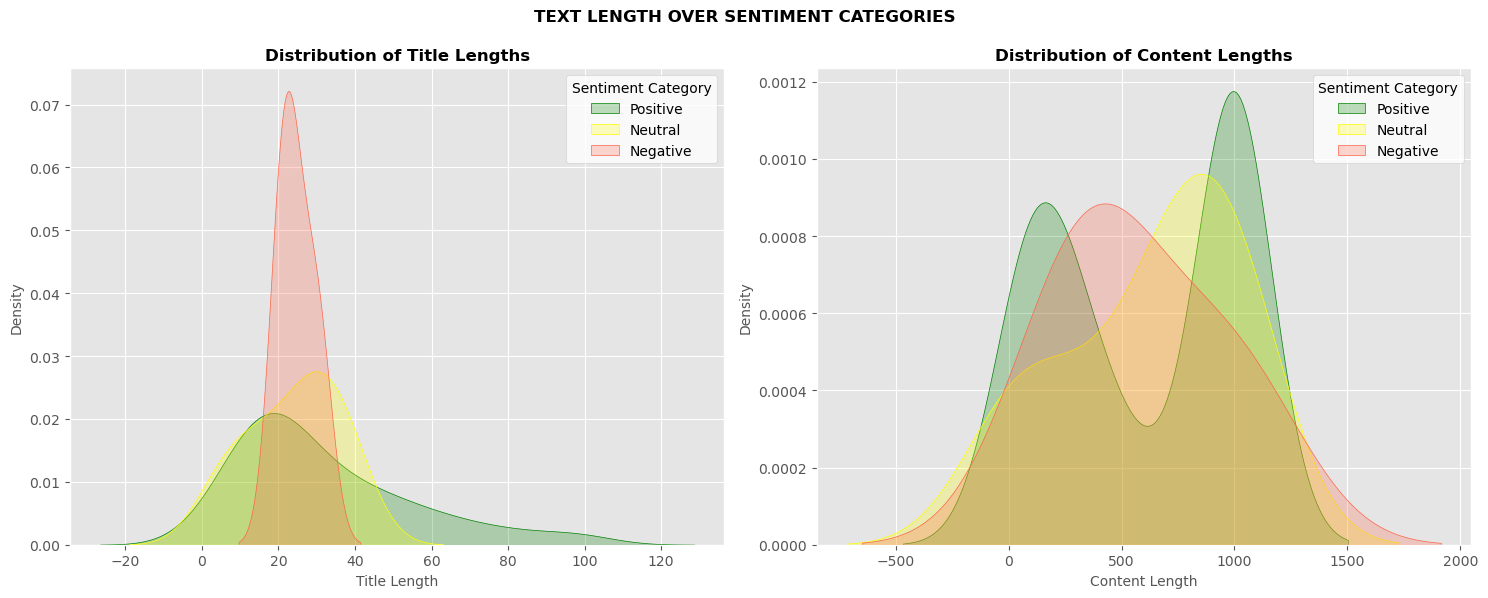

In [30]:
# Title and Content lengths over Sentiment Categories
fig, axs = plt.subplots(1, 2, figsize = (15, 6))

cmap = ['green', 'yellow', 'tomato']
labels = ['Positive', 'Neutral', 'Negative']

for label, clr in zip(labels, cmap):
    sns.kdeplot(data = rws_clean_tag[rws_clean_tag['Sentiment'] == label], x = 'Title Length', color = clr, shade = True, label = label, ax = axs[0])

axs[0].set_title('Distribution of Title Lengths', fontweight = 'bold', fontsize = 12)
axs[0].set_xlabel('Title Length', fontsize = 10)
axs[0].set_ylabel('Density', fontsize = 10)
axs[0].legend(title = 'Sentiment Category').get_frame().set_facecolor('white')

for label, clr in zip(labels, cmap):
    sns.kdeplot(data = rws_clean_tag[rws_clean_tag['Sentiment'] == label], x = 'Content Length', color = clr, shade = True, label = label, ax = axs[1])

axs[1].set_title('Distribution of Content Lengths', fontweight = 'bold', fontsize = 12)
axs[1].set_xlabel('Content Length', fontsize = 10)
axs[1].set_ylabel('Density', fontsize = 10)
axs[1].legend(title = 'Sentiment Category').get_frame().set_facecolor('white')

plt.suptitle('TEXT LENGTH OVER SENTIMENT CATEGORIES', fontweight = 'bold', fontsize = 12, y = 0.99)
plt.tight_layout()
plt.show()

The plot helps visualizing the insight regarding the *overlap* of distributions, meaning the range of text lengths that are common across multiple sentiment categories, and the distribution *spread*, revealing the variability of text lengths for each category.  

Going further with the visual representation of text data, let's create a **Word cloud** based on the pre-processed text ('Clean Title', 'Clean Content'), where the *size* of each word indicates its *frequency* in the review text. Word clouds provide a concise and visually engaging way to represent text data, making them an important tool for initial exploration, analysis, and communication of sentiment-related insights.

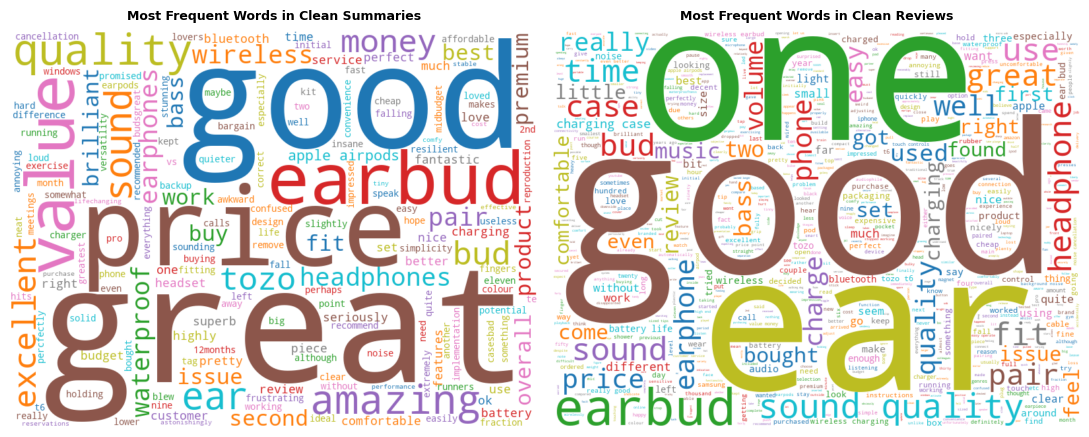

In [31]:
fig, axs = plt.subplots(1, 2, figsize = (11, 5))

# Concatenate all Clean Titles and Contents 
summaries = ' '.join(rws_clean_tag['Clean Title'])
reviews = ' '.join(rws_clean_tag['Clean Content'])

# Generate the WordClouds
wordcloud_summ = WordCloud(width = 800, height = 600, background_color = 'white', colormap = 'tab10', max_words = len(summaries)).generate(str(summaries))
wordcloud_rws = WordCloud(width = 800, height = 600, background_color = 'white', colormap = 'tab10', max_words = len(reviews)).generate(str(reviews))

axs[0].imshow(wordcloud_summ, interpolation = 'bilinear')
axs[0].set_title('Most Frequent Words in Clean Summaries', fontweight = 'bold', fontsize = 9, y = 1.01)
axs[0].axis('off')

axs[1].imshow(wordcloud_rws, interpolation = 'bilinear')
axs[1].set_title('Most Frequent Words in Clean Reviews', fontweight = 'bold', fontsize = 9, y = 1.01)
axs[1].axis('off')

plt.tight_layout()
plt.show()

For each pre-processed Amazon review *('Clean Title', 'Clean Content')*, let's find the **frequency** of each word: 

In [32]:
# Tokenize text to obtain individual words
title_words = word_tokenize(summaries)
text_words = word_tokenize(reviews)

# Count the occurrences of each word
title_word_freq = Counter(title_words)
text_word_freq = Counter(text_words)

# Store word frequencies
title_word_freq_df = pd.DataFrame(list(title_word_freq.items()), columns = ['Word', 'Frequency'])
text_word_freq_df = pd.DataFrame(list(text_word_freq.items()), columns = ['Word', 'Frequency'])

# Sort the DataFrame by frequency in descending order
title_word_freq_df = title_word_freq_df.sort_values(by = 'Frequency', ascending = False)
text_word_freq_df = text_word_freq_df.sort_values(by = 'Frequency', ascending = False)

#title_word_freq_df.head(10)
text_word_freq_df.head(10)

,Word,Frequency
83,good,79
7,sound,75
8,quality,74
344,ear,54
9,case,54
179,earbuds,53
35,one,45
48,charging,44
53,buds,40
152,would,38


Let's compute the percentage of reviews with ***matching*** *frequent* words between titles and contents:

In [33]:
# Merge Dataframes
word_freq = title_word_freq_df.merge(text_word_freq_df, on = 'Word', how = 'outer', suffixes = (' Title', ' Reviews')).dropna()

percentage_matching = (word_freq.shape[0] / len(reviews)) * 100

print(f"Percentage of reviews with matching frequent words: {percentage_matching:.2f}%")

Percentage of reviews with matching frequent words: 0.41%


Let's find the topmost *frequent* ***bigrams*** (pairs of adjacent words) for each pre-processed Amazon review *(Clean Content)*:

In [34]:
bigram_measures = BigramAssocMeasures()                       # provide various measures for association between words in bigrams
finder = BigramCollocationFinder.from_words(text_words)       # find statistically significant word combinations (collocations)
bigram_freq = finder.ngram_fd.items()                         # retrieve the frequency distribution of bigrams

# Store bigram frequencies
bigram_freq_df = pd.DataFrame(list(bigram_freq), columns = ['Bigram', 'Frequency'])

# Sort the DataFrame by frequency in descending order
bigram_freq_df = bigram_freq_df.sort_values(by = 'Frequency', ascending = False)

# Convert the tuples to strings 
bigram_freq_df['Bigram'] = bigram_freq_df['Bigram'].map(lambda bigram: ' '.join(bigram))

bigram_freq_df.head(10)

,Bigram,Frequency
7,sound quality,44
53,charging case,17
928,can not,15
103,battery life,12
1613,ear buds,11
292,wireless charging,9
1325,tozo t6,9
752,really good,8
640,wireless earbuds,7
816,good quality,6


Let's find the topmost *frequent* ***trigrams*** (three adjacent words) for each pre-processed Amazon review:

In [35]:
trigram_measures = TrigramAssocMeasures()                         # provide various measures for association between words in trigrams
finder = TrigramCollocationFinder.from_words(text_words)          # find statistically significant word combinations (collocations)
trigram_freq = finder.ngram_fd.items()                            # retrieve the frequency distribution of trigrams

# Store trigram frequencies
trigram_freq_df = pd.DataFrame(list(trigram_freq), columns = ['Trigram', 'Frequency'])

# Sort the DataFrame by frequency in descending order
trigram_freq_df = trigram_freq_df.sort_values(by = 'Frequency', ascending = False)

# Convert the tuples to strings
trigram_freq_df['Trigram'] = trigram_freq_df['Trigram'].map(lambda trigram: ' '.join(trigram))

trigram_freq_df.head(10)

,Trigram,Frequency
106,good battery life,4
809,sound quality volume,3
453,especially price point,3
1758,good sound quality,3
3978,one hundred and,3
3979,hundred and fifty,3
1841,sound quality great,3
4868,can not believe,2
1688,case four lights,2
1689,four lights lit,2


Then, let's visualize the top **20** most *frequent* ***words***, ***bigrams***, and ***trigrams*** used in Amazon Reviews: 

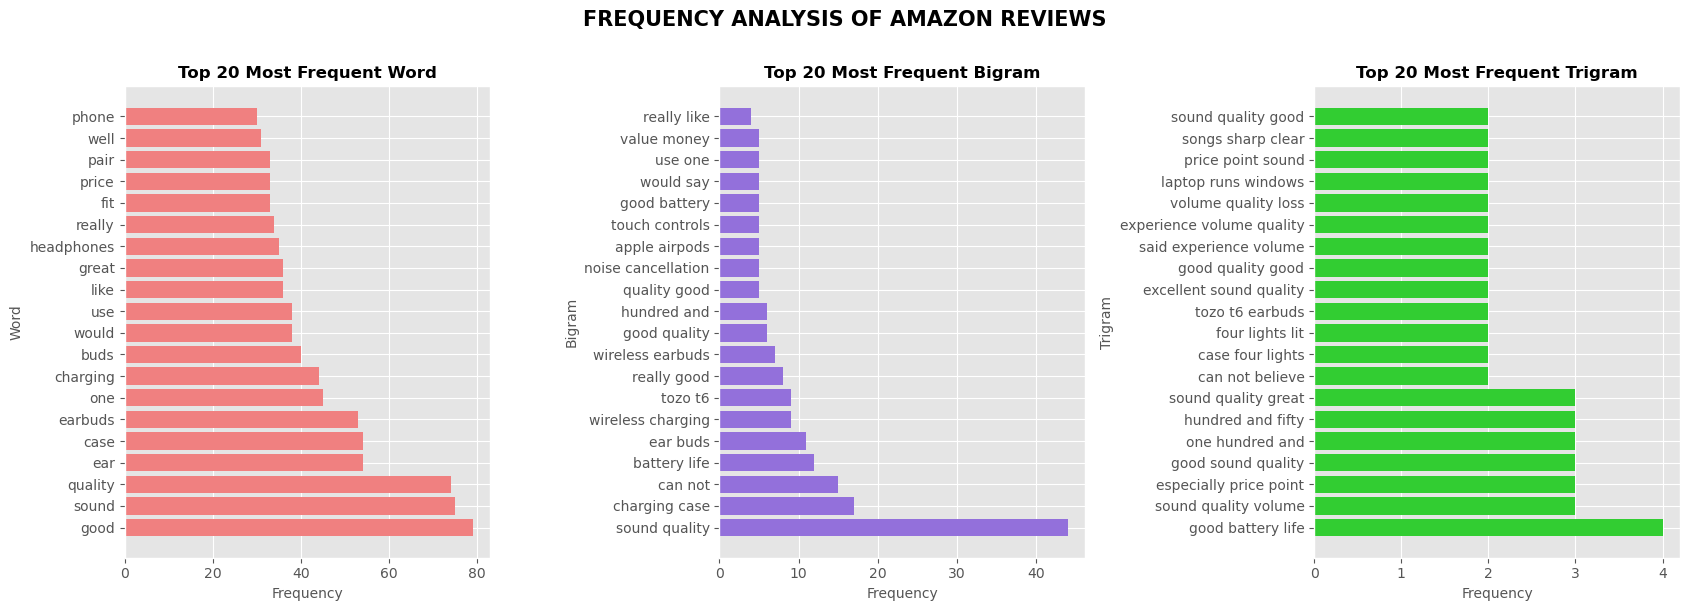

In [36]:
# Top 20 Most Frequent in All Amazon Reviews
fig, axs = plt.subplots(1, 3, figsize = (17, 6))

axs[0].barh(text_word_freq_df['Word'][:20], text_word_freq_df['Frequency'][:20], color = 'lightcoral')
axs[0].set_title('Top 20 Most Frequent Word', fontweight = 'bold', fontsize = 12)
axs[0].set_xlabel('Frequency', fontsize = 10)
axs[0].set_ylabel('Word', fontsize = 10)

axs[1].barh(bigram_freq_df['Bigram'][:20], bigram_freq_df['Frequency'][:20], color = 'mediumpurple')
axs[1].set_title('Top 20 Most Frequent Bigram', fontweight = 'bold', fontsize = 12)
axs[1].set_xlabel('Frequency', fontsize = 10)
axs[1].set_ylabel('Bigram', fontsize = 10)

axs[2].barh(trigram_freq_df['Trigram'][:20], trigram_freq_df['Frequency'][:20], color = 'limegreen')
axs[2].set_title('Top 20 Most Frequent Trigram', fontweight = 'bold', fontsize = 12)
axs[2].set_xlabel('Frequency', fontsize = 10)
axs[2].set_ylabel('Trigram', fontsize = 10)

plt.suptitle('FREQUENCY ANALYSIS OF AMAZON REVIEWS', fontweight = 'bold', fontsize = 15, y = 1.01)
plt.tight_layout()
plt.show()

Let's perform the previous Text Analysis for each ***sentiment*** category, starting from creating a *Word Cloud* visualization based on the pre-processed text:

In [37]:
# Concatenate all Positive reviews
pos_reviews = rws_clean_tag[rws_clean_tag['Sentiment']=='Positive']['Clean Content']
pos_reviews = ' '.join(pos_reviews)

# Concatenate all Neutral reviews
neu_reviews = rws_clean_tag[rws_clean_tag['Sentiment']=='Neutral']['Clean Content']
neu_reviews = ' '.join(neu_reviews)

# Concatenate all Negative reviews
neg_reviews = rws_clean_tag[rws_clean_tag['Sentiment']=='Negative']['Clean Content']
neg_reviews = ' '.join(neg_reviews)

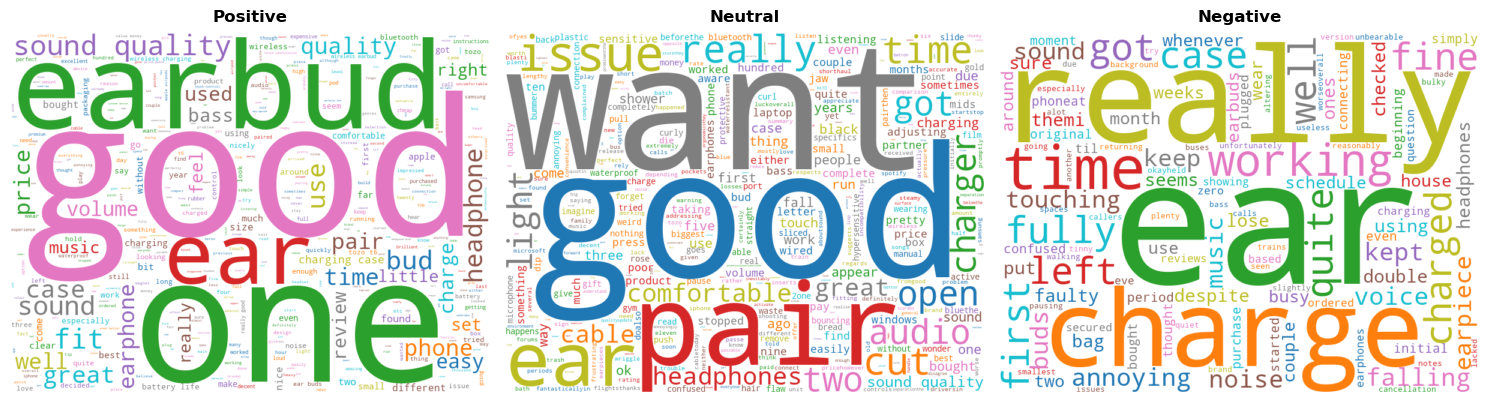

In [38]:
fig, axs = plt.subplots(1, 3, figsize = (15, 10))

# Generate the WordClouds
wordcloud_pos = WordCloud(width = 800, height = 600, background_color = 'white', colormap = 'tab10', max_words = len(pos_reviews)).generate(str(pos_reviews))
wordcloud_neu = WordCloud(width = 800, height = 600, background_color = 'white', colormap = 'tab10', max_words = len(neu_reviews)).generate(str(neu_reviews))
wordcloud_neg = WordCloud(width = 800, height = 600, background_color = 'white', colormap = 'tab10', max_words = len(neg_reviews)).generate(str(neg_reviews))

axs[0].imshow(wordcloud_pos, interpolation = 'bilinear')
axs[0].set_title('Positive', fontweight = 'bold', fontsize = 12, y = 1.01)
axs[0].axis('off')

axs[1].imshow(wordcloud_neu, interpolation = 'bilinear')
axs[1].set_title('Neutral', fontweight = 'bold', fontsize = 12, y = 1.01)
axs[1].axis('off')

axs[2].imshow(wordcloud_neg, interpolation = 'bilinear')
axs[2].set_title('Negative', fontweight = 'bold', fontsize = 12, y = 1.01)
axs[2].axis('off')

plt.tight_layout()
plt.show()

Let's find the topmost *frequent* ***words*** for each pre-processed Amazon review within different *Sentiment* categories:

In [39]:
# Tokenize the text to obtain individual words
words_pos = word_tokenize(pos_reviews)
words_neu = word_tokenize(neu_reviews)
words_neg = word_tokenize(neg_reviews)

# Count the occurrences of each word
word_freq_pos = Counter(words_pos)
word_freq_neu = Counter(words_neu)
word_freq_neg = Counter(words_neg)

# Store word frequencies
word_freq_pos_df = pd.DataFrame(list(word_freq_pos.items()), columns = ['Word', 'Frequency'])
word_freq_neu_df = pd.DataFrame(list(word_freq_neu.items()), columns = ['Word', 'Frequency'])
word_freq_neg_df = pd.DataFrame(list(word_freq_neg.items()), columns = ['Word', 'Frequency'])

# Sort the DataFrame by frequency in descending order
word_freq_pos_df = word_freq_pos_df.sort_values(by = 'Frequency', ascending = False)
word_freq_neu_df = word_freq_neu_df.sort_values(by = 'Frequency', ascending = False)
word_freq_neg_df = word_freq_neg_df.sort_values(by = 'Frequency', ascending = False)

#word_freq_pos_df.head(10)
#word_freq_neu_df.head(10)
#word_freq_neg_df.head(10)

Again, let's find the topmost *frequent* ***bigrams*** for each pre-processed Amazon review *(Clean Content)*:

In [40]:
bigram_measures = BigramAssocMeasures()                          # provide various measures for association between words in bigrams
finder_pos = BigramCollocationFinder.from_words(words_pos)       # find statistically significant word combinations (collocations)
finder_neu = BigramCollocationFinder.from_words(words_neu)
finder_neg = BigramCollocationFinder.from_words(words_neg)
bigram_pos_freq = finder_pos.ngram_fd.items()                    # retrieve the frequency distribution of bigrams
bigram_neu_freq = finder_neu.ngram_fd.items() 
bigram_neg_freq = finder_neg.ngram_fd.items() 

# Store Bigram frequencies
bigram_pos_freq_df = pd.DataFrame(list(bigram_pos_freq), columns = ['Bigram', 'Frequency'])
bigram_neu_freq_df = pd.DataFrame(list(bigram_neu_freq), columns = ['Bigram', 'Frequency'])
bigram_neg_freq_df = pd.DataFrame(list(bigram_neg_freq), columns = ['Bigram', 'Frequency'])

# Sort the DataFrame by frequency in descending order
bigram_pos_freq_df = bigram_pos_freq_df.sort_values(by = 'Frequency', ascending = False)
bigram_neu_freq_df = bigram_neu_freq_df.sort_values(by = 'Frequency', ascending = False)
bigram_neg_freq_df = bigram_neg_freq_df.sort_values(by = 'Frequency', ascending = False)

# Convert the tuples to strings 
bigram_pos_freq_df['Bigram'] = bigram_pos_freq_df['Bigram'].map(lambda bigram: ' '.join(bigram))
bigram_neu_freq_df['Bigram'] = bigram_neu_freq_df['Bigram'].map(lambda bigram: ' '.join(bigram))
bigram_neg_freq_df['Bigram'] = bigram_neg_freq_df['Bigram'].map(lambda bigram: ' '.join(bigram))

#bigram_pos_freq_df.head(10)
#bigram_neu_freq_df.head(10)
#bigram_neg_freq_df.head(10)

Let's find the topmost *frequent* ***trigrams*** for each pre-processed Amazon review according to the *Sentiment* category:

In [41]:
trigram_measures = TrigramAssocMeasures()                            # provide various measures for association between words in trigrams
finder_pos = TrigramCollocationFinder.from_words(words_pos)          # find statistically significant word combinations (collocations)
finder_neu = TrigramCollocationFinder.from_words(words_neu)
finder_neg = TrigramCollocationFinder.from_words(words_neg)
trigram_pos_freq = finder_pos.ngram_fd.items()                       # retrieve the frequency distribution of trigrams
trigram_neu_freq = finder_neu.ngram_fd.items()
trigram_neg_freq = finder_neg.ngram_fd.items()

# Store trigram frequencies
trigram_pos_freq_df = pd.DataFrame(list(trigram_pos_freq), columns = ['Trigram', 'Frequency'])
trigram_neu_freq_df = pd.DataFrame(list(trigram_neu_freq), columns = ['Trigram', 'Frequency'])
trigram_neg_freq_df = pd.DataFrame(list(trigram_neg_freq), columns = ['Trigram', 'Frequency'])

# Sort the DataFrame by frequency in descending order
trigram_pos_freq_df = trigram_pos_freq_df.sort_values(by = 'Frequency', ascending = False)
trigram_neu_freq_df = trigram_neu_freq_df.sort_values(by = 'Frequency', ascending = False)
trigram_neg_freq_df = trigram_neg_freq_df.sort_values(by = 'Frequency', ascending = False)

# Convert the tuples to strings
trigram_pos_freq_df['Trigram'] = trigram_pos_freq_df['Trigram'].map(lambda trigram: ' '.join(trigram))
trigram_neu_freq_df['Trigram'] = trigram_neu_freq_df['Trigram'].map(lambda trigram: ' '.join(trigram))
trigram_neg_freq_df['Trigram'] = trigram_neg_freq_df['Trigram'].map(lambda trigram: ' '.join(trigram))

#trigram_pos_freq_df.head(10)

Once computed the frequencies, let's visualize the top **20** most *frequent* ***words***, ***bigrams***, and ***trigrams*** used in Amazon Reviews for each *Sentiment* category separately:

##### POSITIVE SENTIMENT

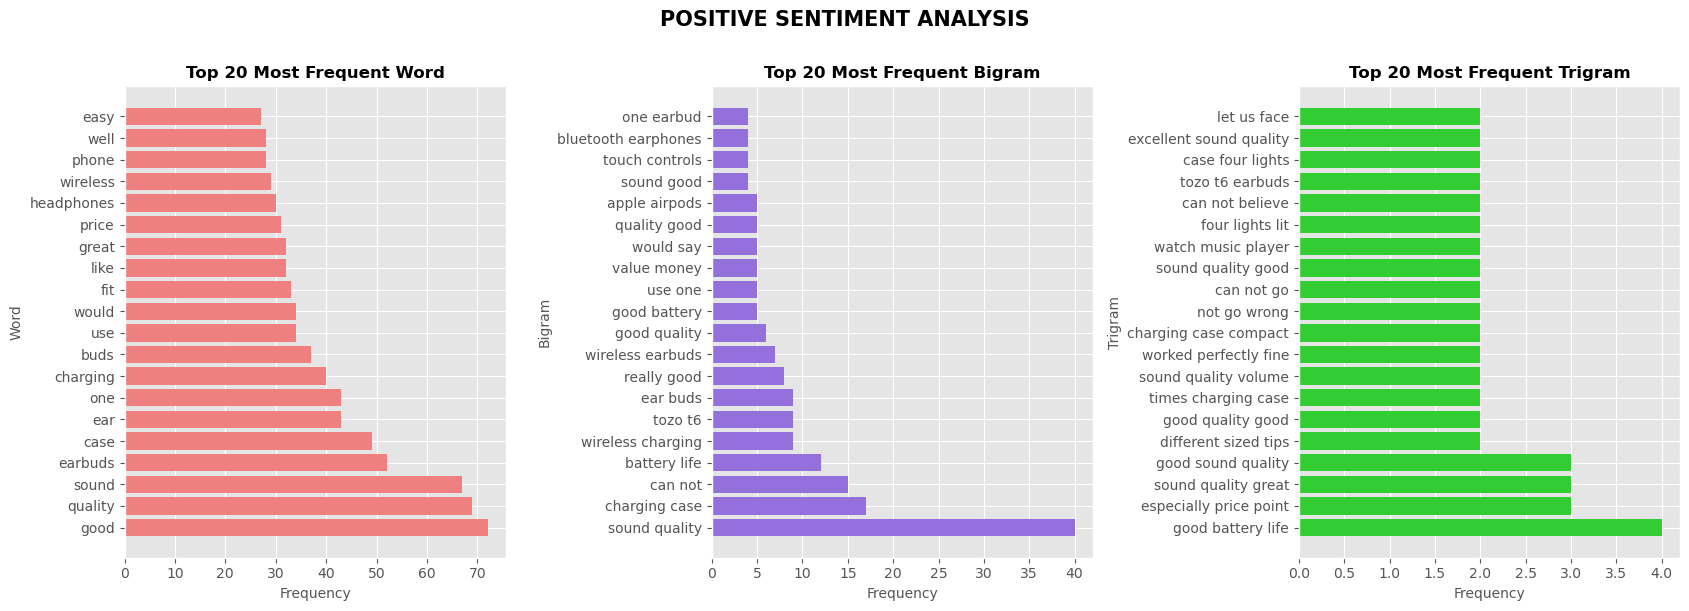

In [42]:
# Top 20 Most Frequent - POSITIVE
fig, axs = plt.subplots(1, 3, figsize = (17, 6))

axs[0].barh(word_freq_pos_df['Word'][:20], word_freq_pos_df['Frequency'][:20], color = 'lightcoral')
axs[0].set_title('Top 20 Most Frequent Word', fontweight = 'bold', fontsize = 12)
axs[0].set_xlabel('Frequency', fontsize = 10)
axs[0].set_ylabel('Word', fontsize = 10)

axs[1].barh(bigram_pos_freq_df['Bigram'][:20], bigram_pos_freq_df['Frequency'][:20], color = 'mediumpurple')
axs[1].set_title('Top 20 Most Frequent Bigram', fontweight = 'bold', fontsize = 12)
axs[1].set_xlabel('Frequency', fontsize = 10)
axs[1].set_ylabel('Bigram', fontsize = 10)

axs[2].barh(trigram_pos_freq_df['Trigram'][:20], trigram_pos_freq_df['Frequency'][:20], color = 'limegreen')
axs[2].set_title('Top 20 Most Frequent Trigram', fontweight = 'bold', fontsize = 12)
axs[2].set_xlabel('Frequency', fontsize = 10)
axs[2].set_ylabel('Trigram', fontsize = 10)

plt.suptitle('POSITIVE SENTIMENT ANALYSIS', fontweight = 'bold', fontsize = 15, y = 1.01)
plt.tight_layout()
plt.show()

##### NEUTRAL SENTIMENT

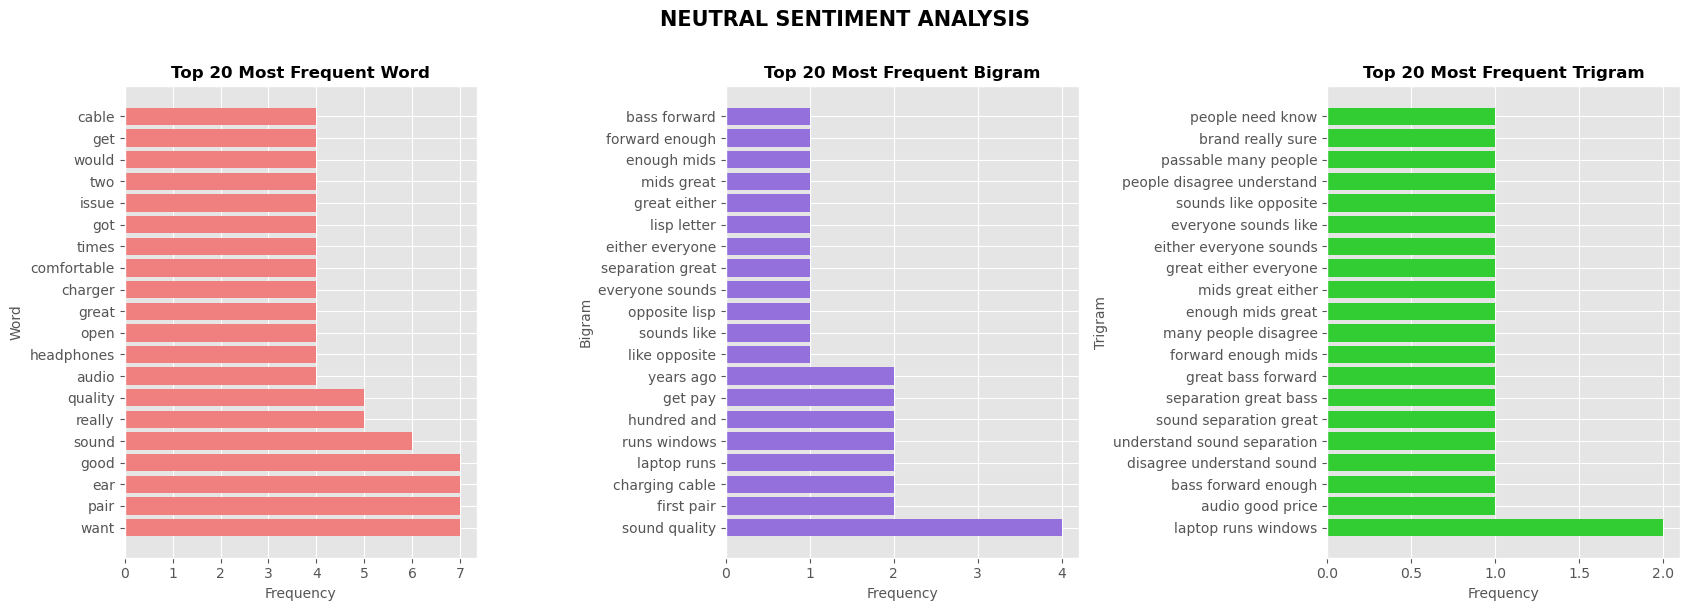

In [43]:
# Top 20 Most Frequent - NEUTRAL
fig, axs = plt.subplots(1, 3, figsize = (17, 6))

axs[0].barh(word_freq_neu_df['Word'][:20], word_freq_neu_df['Frequency'][:20], color = 'lightcoral')
axs[0].set_title('Top 20 Most Frequent Word', fontweight = 'bold', fontsize = 12)
axs[0].set_xlabel('Frequency', fontsize = 10)
axs[0].set_ylabel('Word', fontsize = 10)

axs[1].barh(bigram_neu_freq_df['Bigram'][:20], bigram_neu_freq_df['Frequency'][:20], color = 'mediumpurple')
axs[1].set_title('Top 20 Most Frequent Bigram', fontweight = 'bold', fontsize = 12)
axs[1].set_xlabel('Frequency', fontsize = 10)
axs[1].set_ylabel('Bigram', fontsize = 10)

axs[2].barh(trigram_neu_freq_df['Trigram'][:20], trigram_neu_freq_df['Frequency'][:20], color = 'limegreen')
axs[2].set_title('Top 20 Most Frequent Trigram', fontweight = 'bold', fontsize = 12)
axs[2].set_xlabel('Frequency', fontsize = 10)
axs[2].set_ylabel('Trigram', fontsize = 10)

plt.suptitle('NEUTRAL SENTIMENT ANALYSIS', fontweight = 'bold', fontsize = 15, y = 1.01)
plt.tight_layout()
plt.show()

##### NEGATIVE SENTIMENT

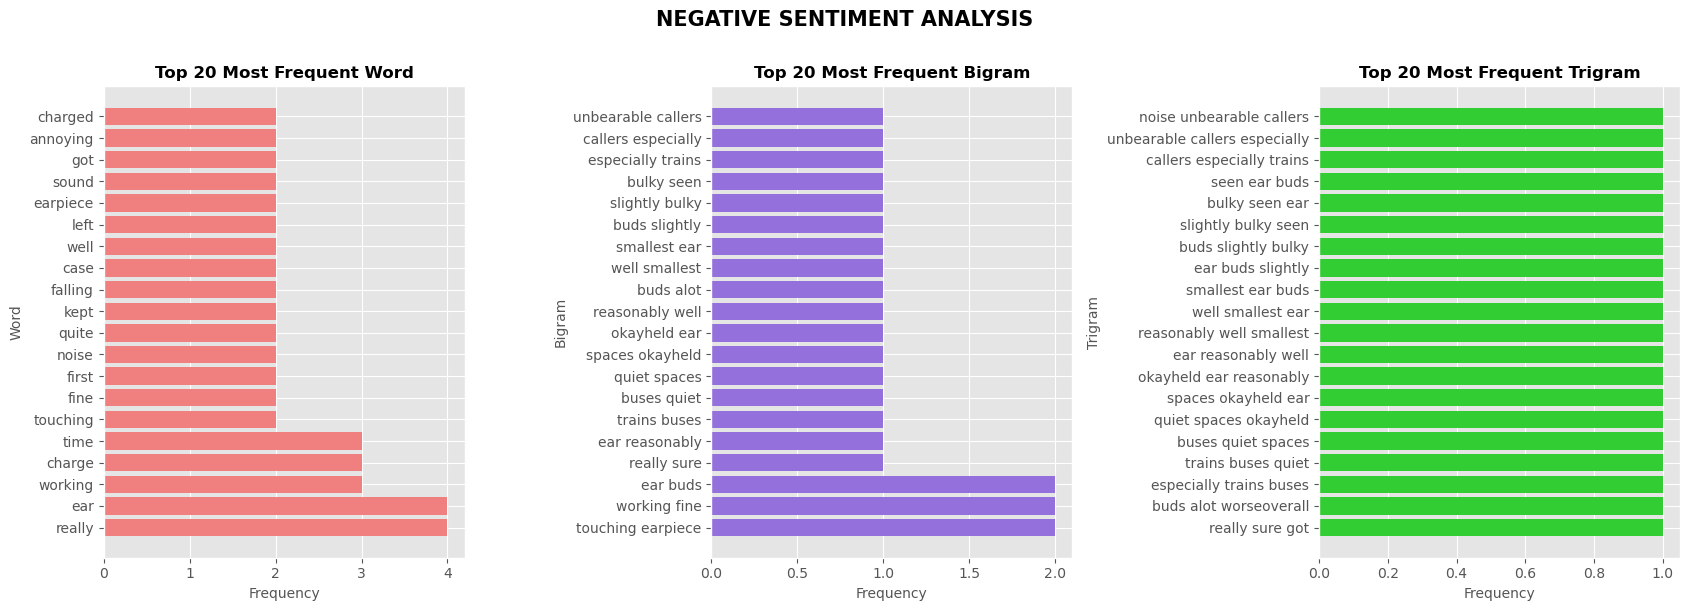

In [44]:
# Top 20 Most Frequent - NEGATIVE
fig, axs = plt.subplots(1, 3, figsize = (17, 6))

axs[0].barh(word_freq_neg_df['Word'][:20], word_freq_neg_df['Frequency'][:20], color = 'lightcoral')
axs[0].set_title('Top 20 Most Frequent Word', fontweight = 'bold', fontsize = 12)
axs[0].set_xlabel('Frequency', fontsize = 10)
axs[0].set_ylabel('Word', fontsize = 10)

axs[1].barh(bigram_neg_freq_df['Bigram'][:20], bigram_neg_freq_df['Frequency'][:20], color = 'mediumpurple')
axs[1].set_title('Top 20 Most Frequent Bigram', fontweight = 'bold', fontsize = 12)
axs[1].set_xlabel('Frequency', fontsize = 10)
axs[1].set_ylabel('Bigram', fontsize = 10)

axs[2].barh(trigram_neg_freq_df['Trigram'][:20], trigram_neg_freq_df['Frequency'][:20], color = 'limegreen')
axs[2].set_title('Top 20 Most Frequent Trigram', fontweight = 'bold', fontsize = 12)
axs[2].set_xlabel('Frequency', fontsize = 10)
axs[2].set_ylabel('Trigram', fontsize = 10)

plt.suptitle('NEGATIVE SENTIMENT ANALYSIS', fontweight = 'bold', fontsize = 15, y = 1.01)
plt.tight_layout()
plt.show()

In [45]:
# Save
rws_eda = rws_clean_tag.loc[:, ['Clean Title', 'Clean Content', 'Rating', 'Sentiment', 'Target']]
rws_eda.to_csv('rws_eda.csv')
rws_eda.head(1)

,Clean Title,Clean Content,Rating,Sentiment,Target
0,second time buying headphones overall value money,lost first pair replaced really like fit sound...,4,Positive,2
